In [97]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [98]:
# BMI 계산 후 레이블 리턴하는 함수
# bmi = kg / m * m
#     18.5 미만 : thin
#     25 미만 : normal
#     25 이상 : fat
def bmi_cal(kg, meter):
  bmi = kg / (meter * meter / 10000)
  if bmi < 18.5:
    return 'thin'
  elif bmi < 25:
    return 'normal'
  else:
    return 'fat'
# 키 : cm (120 ~ 200)
# 몸무게 : kg(30 ~ 90)
count = {'thin' : 0,'normal' : 0, 'fat' : 0 }
# csv 파일 생성
with open('./bmi.csv', 'w', encoding="UTF-8") as file:
# 데이터 무작위로 20000개 생성

  file.write('height,weight,label\n')
  for _ in range(20000):
    m = np.random.randint(120,201) 
    k = np.random.randint(30,91)
    label = bmi_cal(k,m)
  #count[label] += 1
    file.write(f'{m},{k},{label}\n')
print(count)

{'thin': 0, 'normal': 0, 'fat': 0}


In [99]:
import tensorflow.compat.v1 as tf

In [100]:
# {thin : ?, normal : ?, fat : ?}
csv = pd.read_csv('./bmi.csv')

# 키와 몸무게 기초 통계량 확인
csv.describe()

# csv.head()

csv.tail()




,height,weight,label
19995,139,53,fat
19996,188,56,thin
19997,134,88,fat
19998,139,86,fat
19999,173,34,thin


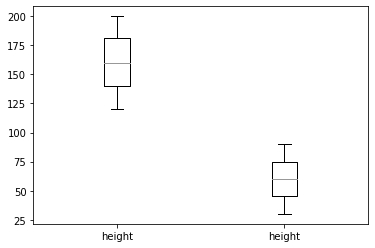

In [101]:
#boxplot으로 h,w 분포 확인
import matplotlib.pyplot as plt

plt.boxplot([csv['height'], csv['weight']], labels=['height', 'height'])
plt.show()

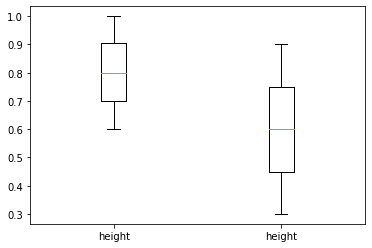

In [102]:
# 복제본
csv1 = csv.copy()

# 키가 2미터를 넘지 않고, 몸무게는 100키로가 넘지 않는다는 가정하에...
# 정규화
csv1['height'] = csv1['height'] / 200
csv1['weight'] = csv1['weight'] / 100

# boxplot으로 분포가 장 되었는지 확인
plt.boxplot([csv1['height'], csv1['weight']], labels=['height', 'height'])
plt.show()

In [103]:
# 레이블을 배열로 변환
# str -> One-Hot Encoding으로 converting
# thin : [1,0,0], normal : [0,1,0], fat : [0,0,1]
ohe = {'thin' : [1,0,0],'normal' : [0,1,0],'fat' : [0,0,1]}
# One-hot Encoding으로 바꾼 컬럼을 하나 더 생성
csv1['label_ohe'] = csv1['label'].apply(lambda x : np.array(ohe[x]))

csv1

,height,weight,label,label_ohe
0,0.855,0.75,fat,"[0, 0, 1]"
1,0.785,0.39,thin,"[1, 0, 0]"
2,0.710,0.81,fat,"[0, 0, 1]"
3,0.600,0.30,normal,"[0, 1, 0]"
4,0.845,0.51,thin,"[1, 0, 0]"
...,...,...,...,...
19995,0.695,0.53,fat,"[0, 0, 1]"
19996,0.940,0.56,thin,"[1, 0, 0]"
19997,0.670,0.88,fat,"[0, 0, 1]"
19998,0.695,0.86,fat,"[0, 0, 1]"


In [104]:
# 테스트를 위한 데이터 분리 (테스트용 데이터)
# 아래의 5000
test_csv = csv1[15000:]
test_pat = test_csv[['height', 'weight']]
test_ans = list(test_csv['label_ohe'])

print(test_pat.head())
print(test_ans[:5])

       height  weight
15000   0.855    0.74
15001   0.740    0.39
15002   0.735    0.30
15003   0.870    0.69
15004   0.905    0.49
[array([0, 0, 1]), array([1, 0, 0]), array([1, 0, 0]), array([0, 1, 0]), array([1, 0, 0])]


In [105]:
# tensorflow의 학습모델 구성
tf.reset_default_graph()
# 기존에 생성된 데이터 플로우 그래프를 모두 삭제하고 reset 시켜서 중복 방지

In [106]:
# tf.compat.v1.disable_eager_execution()

In [107]:
# 신경망 구성

# 데이터 플로우 그래프 구축하기
# placeholder 생성

# 키와 몸무게 데이터 넣기
x = tf.placeholder(tf.float32, [None, 2])

# 정답 label
y_ = tf.placeholder(tf.float32, [None, 3])

# 변수 선언
W = tf.Variable(tf.zeros([2, 3])) # 가중치
b = tf.Variable(tf.zeros([3])) # 바이어스(bias) : 뉴런의 활성화를 조절

# 소프트맥스 회귀 : one-hot encoding과 연결하기 위해서 0-1 사이의 숫자로 바꾸는 역할
y = tf.nn.softmax(tf.matmul(x, W) + b)

# 손실함수의 cross entropy : 분류 모델이 얼마나 잘 수행되는지 측정하기 위해서 사용하는 지표
#   y_ * tf.log(y) 에는 데이터들의 크로스엔트로피들의 2차원 텐서가 들어있음
#   reduce_sum() 함수는 지정된 차원에 따라서 평균을 내는 함수
# 크로스 엔트로피(데이터의 불확실성)에서는 실제값과 예측값이 맞는 경우 0으로 수렴하고,
# 값이 틀릴경우는 값이 커지기 때문에... -> 실제값과 예측값의 차이를 줄이기 위한 방법이다.

ce = -tf.reduce_sum(y * tf.log(y))

# 최적화 : 경사하강법(함수의 기울기(경사)를 구하고, 경사의 절대값이 낮은 쪽으로 이동시켜서
#                     극값에 이를 때까지 반복시키는 것)
optimizer = tf.train.GradientDescentOptimizer(0.01) # 0.01 : 학습 계수 (하강 간격)

# greadient : 경사 / Desenct : 내려감 >> 경사를 따라 내려가는 알고리즘
# optimizer : 각각의 변수에 기대되는 값과 손실의 도함수의 정도에 따라서 변수의 값을 변경해주는 것
#   도함수  : 원래 함수를 미분해서 얻어낸 함수 >> 어떤 점에서의 기울기
# 텐서플로  : 도함수를 자동으로 만들어줌...!

# 가중치, 편차를 보정
optimizer1 = optimizer.minimize(ce)

# 정답률 구하기
# tf.argmax(y, 1)는 모델이 생각할 때 가장 적합하다고 판단한 레이블
# tf.argmax(y_, 1)는 실제 레이블
# tf.equal()를 이용해서 예측이 맞았는지 확인
predict = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

# 평균 구하기
score = tf.reduce_mean(tf.cast(predict, tf.float32))

print(predict)
print(score)

Tensor("Equal:0", shape=(None,), dtype=bool)
Tensor("Mean:0", shape=(), dtype=float32)


In [108]:
# 실제 실행이 이루어지는 Session

with tf.Session() as sess:
  f_bmi = tf.summary.FileWriter('into_bmi', graph=sess.graph) # 그래프를 저장할 파일을 지정
  sess.run(tf.global_variables_initializer()) # 변수 초기화

  # 학습시키기 - 3500번
  for step in range(3500):
    # 0 ~ 14999 까지를 100개씩 학습
    i = (step * 100) % 14000

    # 학습이 되는 행을 추출
    rows = csv1[1 + i : 1 + i + 100]

    # feature_data, label_data를 분리
    xf = rows[['height', 'weight']]
    yl = list(rows['label_ohe'])

    feed_dict = {x : xf, y_ : yl}
    sess.run(optimizer1, feed_dict=feed_dict)

    # 학습된 모델을 가지고 test를 진행할 때 중간중간 콘솔에서 확인할 수 있도록
    if step % 500 == 0: # 500개 마다
      ce1 = sess.run(ce, feed_dict={x : test_pat, y_ : test_ans})
      ac = sess.run(score, feed_dict={x : test_pat, y_ : test_ans})
      print('단계=', step, '크로스엔트로피=', ce1, '정확도=', ac)

  # 최종 정답률(정확도)
  ac = sess.run(score, feed_dict={x : test_pat, y_ : test_ans})
  print('정확도=', ac)

단계= 0 크로스엔트로피= 5493.0522 정확도= 0.3204
단계= 500 크로스엔트로피= 5493.0522 정확도= 0.3204
단계= 1000 크로스엔트로피= 5493.0522 정확도= 0.3204
단계= 1500 크로스엔트로피= 5493.0522 정확도= 0.3204
단계= 2000 크로스엔트로피= 5493.0522 정확도= 0.3204
단계= 2500 크로스엔트로피= 5493.0522 정확도= 0.3204
단계= 3000 크로스엔트로피= 5493.0522 정확도= 0.3204
정확도= 0.3204
